In [63]:
import os
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import statsmodels.api as sm

### Load data
First let's just load our 4 CSVs into some pandas dataframes.

In [14]:
data_file_names = !ls ./data
data = {}

for file_name in data_file_names:
    data_type = file_name.split(' - ')[1].split('.')[0]
    data_type = '_'.join(data_type.lower().split(' '))
    data[data_type] = pd.read_csv(os.path.join('./data', file_name))
data.keys()

dict_keys(['eating_times', 'quantified_mind_results', 'sleep', 'subjective'])

# Analysis Part 1: Coffee's effect on quantified mind results

In [15]:
true_label_df = data['subjective'][~data['subjective']['Regular vs. Decaf'].isna()]
true_label_df

,Date,Label,Timestamp,Alertness (1-5),Sharpness (1-5),Mood (1-5),Headache (Y/M/N),Regular vs. Decaf Prediction,Regular vs. Decaf
0,03/02,Pre-coffee,7:00 AM,2,2,3,N,Regular,Regular
5,03/03,Post-coffee,8:10 AM,4,3,3,N,Regular,Regular
9,03/04,Post-coffee,8:56,3,4,4,N,Regular,Decaf
13,03/05,Post-coffee,8:08 AM,3,4,3,M,Regular,Decaf
17,03/06,Post-coffee,8:15,2,2,2,N,Decaf,Regular
21,03/07,Post-Coffee,11:06,4,4,4,M,Decaf,Decaf
25,03/08,Post-coffee,11:28,4,4,4,N,Regular,Regular
29,03/09,Post-coffee,8:57,3,3,3,N,Decaf,Regular
33,03/10,Post-coffee,8:41 AM,3,3,3,N,Decaf,Decaf
37,03/11,Post-coffee,9:23 AM,4,4,3,Y,Decaf,Decaf


In [16]:
regular_vs_decaf_df = true_label_df[['Date', 'Regular vs. Decaf']]
regular_vs_decaf_df = regular_vs_decaf_df.rename(columns={"Date": "date", "Regular vs. Decaf": "coffee_type"})
regular_vs_decaf_df["coffee_type"] = regular_vs_decaf_df["coffee_type"].str.strip()
regular_vs_decaf_df["coffee_type"] = regular_vs_decaf_df["coffee_type"].astype('category')
regular_vs_decaf_df["date"] = regular_vs_decaf_df["date"].str.cat(["2020"] * len(regular_vs_decaf_df), "/")
regular_vs_decaf_df["date"] = pd.to_datetime(regular_vs_decaf_df["date"])
regular_vs_decaf_df

,date,coffee_type
0,2020-03-02,Regular
5,2020-03-03,Regular
9,2020-03-04,Decaf
13,2020-03-05,Decaf
17,2020-03-06,Regular
21,2020-03-07,Decaf
25,2020-03-08,Regular
29,2020-03-09,Regular
33,2020-03-10,Decaf
37,2020-03-11,Decaf


In [17]:
quantified_mind_df = data['quantified_mind_results']
quantified_mind_df

,Session,Date,Time,Alertness,Sharpness,Coding,Design Copy,Finger Tapping,Simple Reaction Time,Sorting,Visual Backward Digit Span
0,1,03/02,7:29:00 AM,2,5,535.836,482.493,434.962,430.600,551.951,468.482
1,2,03/03,7:28:00 AM,3,3,524.798,577.790,361.865,571.783,572.558,549.522
2,3,03/04,8:57 AM,3,4,547.560,504.674,483.520,523.819,596.365,548.020
3,4,03/05,8:09 AM,3,4,593.359,513.681,666.700,594.710,602.009,667.308
4,5,03/06,8:16 AM,2,4,534.533,649.864,698.195,583.635,603.064,622.449
5,6,03/07,11:07 AM,4,4,575.182,510.128,627.418,560.807,604.601,662.850
6,7,03/08,11:35 AM,4,4,567.461,570.271,668.083,605.748,585.448,691.603
7,8,03/09,9:05 AM,3,3,533.702,603.636,683.641,666.264,611.088,569.569
8,9,03/10,8:41 AM,3,3,524.298,641.947,657.029,550.512,593.181,630.420
9,10,03/11,9:23 AM,4,4,528.402,652.890,667.696,568.600,603.264,685.057


In [18]:
quantified_mind_df = data['quantified_mind_results']
quantified_mind_df = quantified_mind_df.rename(columns={"Date": "date"})

quantified_mind_df["date"] = quantified_mind_df["date"].str.cat(["2020"] * len(quantified_mind_df), "/")
quantified_mind_df["date"] = pd.to_datetime(quantified_mind_df["date"])
quantified_mind_df

,Session,date,Time,Alertness,Sharpness,Coding,Design Copy,Finger Tapping,Simple Reaction Time,Sorting,Visual Backward Digit Span
0,1,2020-03-02,7:29:00 AM,2,5,535.836,482.493,434.962,430.600,551.951,468.482
1,2,2020-03-03,7:28:00 AM,3,3,524.798,577.790,361.865,571.783,572.558,549.522
2,3,2020-03-04,8:57 AM,3,4,547.560,504.674,483.520,523.819,596.365,548.020
3,4,2020-03-05,8:09 AM,3,4,593.359,513.681,666.700,594.710,602.009,667.308
4,5,2020-03-06,8:16 AM,2,4,534.533,649.864,698.195,583.635,603.064,622.449
5,6,2020-03-07,11:07 AM,4,4,575.182,510.128,627.418,560.807,604.601,662.850
6,7,2020-03-08,11:35 AM,4,4,567.461,570.271,668.083,605.748,585.448,691.603
7,8,2020-03-09,9:05 AM,3,3,533.702,603.636,683.641,666.264,611.088,569.569
8,9,2020-03-10,8:41 AM,3,3,524.298,641.947,657.029,550.512,593.181,630.420
9,10,2020-03-11,9:23 AM,4,4,528.402,652.890,667.696,568.600,603.264,685.057


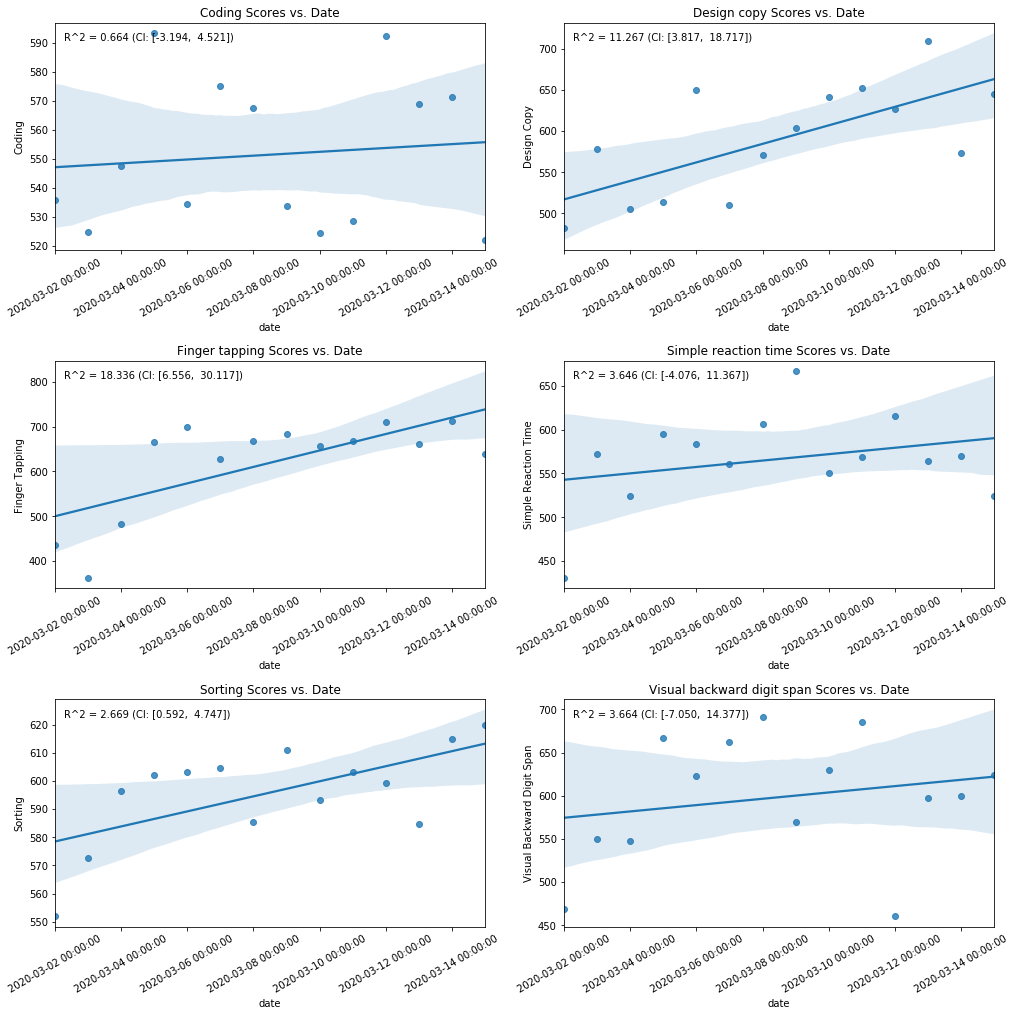

In [88]:
from datetime import datetime
test_result_cols = [
    "Coding", "Design Copy", "Finger Tapping", "Simple Reaction Time", "Sorting", "Visual Backward Digit Span"
]
fig, axs = plt.subplots(nrows=len(test_result_cols) // 2,ncols=2, figsize=(14, 14), constrained_layout=True)
quantified_mind_df["date_millis"] = pd.to_datetime(quantified_mind_df['date']).apply(
    lambda date: date.toordinal()
)
for i, col in enumerate(test_result_cols):
    ax = axs[i // 2, i % 2]
    
    res = sns.regplot(x='date_millis', y=col, ax=ax, data=quantified_mind_df)
    ax.set_xlabel('date')
    new_labels = [datetime.fromordinal(int(item)) for item in ax.get_xticks()]
    ax.set_xticklabels(new_labels, rotation=30)
    ax.set_title(f"{col.capitalize()} Scores vs. Date")
    X = quantified_mind_df['date_millis'].values - np.min(quantified_mind_df['date_millis'].values)
    X = sm.add_constant(X)
    results = sm.OLS(labeled_sleep_qm_df[col].values, X).fit()
    ci = results.conf_int(alpha=0.05, cols=None)
    intercept, slope = results.params
    anc = AnchoredText(
        f"R^2 = {slope:.3f} (CI: [{ci[1, 0]:.3f}, {ci[1, 1]: .3f}])", loc="upper left", frameon=False
    )
    ax.add_artist(anc)

In [20]:
labeled_quantified_mind_df = pd.merge(quantified_mind_df, regular_vs_decaf_df)
labeled_quantified_mind_df['coffee_type'].unique()

[Regular, Decaf]
Categories (2, object): [Regular, Decaf]

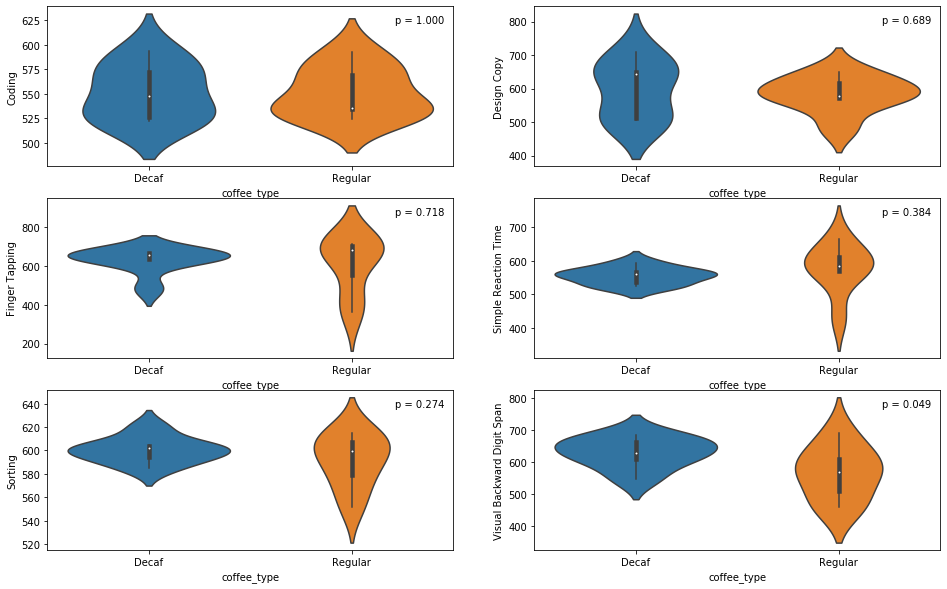

In [84]:

fig, axs = plt.subplots(nrows=len(test_result_cols) // 2, ncols=2, figsize=(16, 10))
for i, col in enumerate(test_result_cols):
    ax = axs[i // 2, i % 2]
    sns.violinplot(x=labeled_quantified_mind_df["coffee_type"], y=labeled_quantified_mind_df[col], ax=ax)
    test_stat, pval = scipy.stats.ttest_rel(
        decaf_quantified_mind_results_df[col],
        regular_quantified_mind_results_df[col]
    )
    anc = AnchoredText(f"p = {pval:.3f}", loc="upper right", frameon=False)
    ax.add_artist(anc)

In [22]:
test_result_cols = [
    "Coding", "Design Copy", "Finger Tapping", "Simple Reaction Time", "Sorting", "Visual Backward Digit Span"
]
decaf_quantified_mind_results_df = labeled_quantified_mind_df[labeled_quantified_mind_df['coffee_type'] == 'Decaf']
regular_quantified_mind_results_df = labeled_quantified_mind_df[
    labeled_quantified_mind_df['coffee_type'] == 'Regular'
]

for col in test_result_cols:
    test_stat, pval = scipy.stats.ttest_rel(
        decaf_quantified_mind_results_df[col],
        regular_quantified_mind_results_df[col]
    )
    print(f"{col}: {pval}")

Coding: 0.9995078098443206
Design Copy: 0.6885721000356676
Finger Tapping: 0.717566454283634
Simple Reaction Time: 0.384136908350378
Sorting: 0.2742635100841052
Visual Backward Digit Span: 0.04899206483679553


### Summary
Seems fairly clear (at least to my satisfaction) that there's no detectable effect of regular vs. decaf coffee on my QM results.

# Analysis Part 2: Looking at the effect of sleep on QM results

In [23]:
data['sleep']

,Day,Time in bed,Time awake
0,03/02,0:00:00,6:30
1,03/03,23:00:00,6:30
2,03/04,23:30:00,7:40
3,03/05,23:00:00,7:30
4,03/06,0:50:00,7:00
5,03/07,0:30:00,9:45
6,03/08,0:50:00,9:00 AM
7,03/09,0:15:00,8:00 AM
8,03/10,0:15:00,7:40 AM
9,03/11,23:30:00,8:15 AM


In [24]:
def get_sleep_duration(row):
    sleep_start, sleep_end = row['sleep_start'], row['sleep_end']
    if sleep_start < sleep_end:
        return sleep_end - sleep_start
    else:
        return sleep_end - sleep_start + pd.DateOffset(1)

sleep_df = data['sleep']
sleep_df = sleep_df.rename(columns={"Day": "date"})
sleep_df["date"] = sleep_df["date"].str.cat(["2020"] * len(sleep_df), "/")
sleep_df["date"] = pd.to_datetime(sleep_df["date"])
sleep_df["sleep_start"] = pd.to_datetime(sleep_df['Time in bed'], format='%H:%M:%S')
sleep_df["sleep_end"] = sleep_df['Time awake'].str.strip(' AM')
sleep_df["sleep_end"] = pd.to_datetime(sleep_df['sleep_end'], format='%H:%M')
sleep_df["sleep_duration"] = sleep_df[['sleep_start', 'sleep_end']].apply(get_sleep_duration, axis=1)
sleep_df["sleep_duration"] = sleep_df["sleep_duration"].astype('timedelta64[m]')
sleep_df

,date,Time in bed,Time awake,sleep_start,sleep_end,sleep_duration
0,2020-03-02,0:00:00,6:30,1900-01-01 00:00:00,1900-01-01 06:30:00,390.0
1,2020-03-03,23:00:00,6:30,1900-01-01 23:00:00,1900-01-01 06:30:00,450.0
2,2020-03-04,23:30:00,7:40,1900-01-01 23:30:00,1900-01-01 07:40:00,490.0
3,2020-03-05,23:00:00,7:30,1900-01-01 23:00:00,1900-01-01 07:30:00,510.0
4,2020-03-06,0:50:00,7:00,1900-01-01 00:50:00,1900-01-01 07:00:00,370.0
5,2020-03-07,0:30:00,9:45,1900-01-01 00:30:00,1900-01-01 09:45:00,555.0
6,2020-03-08,0:50:00,9:00 AM,1900-01-01 00:50:00,1900-01-01 09:00:00,490.0
7,2020-03-09,0:15:00,8:00 AM,1900-01-01 00:15:00,1900-01-01 08:00:00,465.0
8,2020-03-10,0:15:00,7:40 AM,1900-01-01 00:15:00,1900-01-01 07:40:00,445.0
9,2020-03-11,23:30:00,8:15 AM,1900-01-01 23:30:00,1900-01-01 08:15:00,525.0


In [25]:
labeled_sleep_df = pd.merge(sleep_df, regular_vs_decaf_df)
labeled_sleep_qm_df = pd.merge(labeled_sleep_df, quantified_mind_df)
labeled_sleep_qm_df.head()

,date,Time in bed,Time awake,sleep_start,sleep_end,sleep_duration,coffee_type,Session,Time,Alertness,Sharpness,Coding,Design Copy,Finger Tapping,Simple Reaction Time,Sorting,Visual Backward Digit Span
0,2020-03-02,0:00:00,6:30,1900-01-01 00:00:00,1900-01-01 06:30:00,390.0,Regular,1,7:29:00 AM,2,5,535.836,482.493,434.962,430.600,551.951,468.482
1,2020-03-03,23:00:00,6:30,1900-01-01 23:00:00,1900-01-01 06:30:00,450.0,Regular,2,7:28:00 AM,3,3,524.798,577.790,361.865,571.783,572.558,549.522
2,2020-03-04,23:30:00,7:40,1900-01-01 23:30:00,1900-01-01 07:40:00,490.0,Decaf,3,8:57 AM,3,4,547.560,504.674,483.520,523.819,596.365,548.020
3,2020-03-05,23:00:00,7:30,1900-01-01 23:00:00,1900-01-01 07:30:00,510.0,Decaf,4,8:09 AM,3,4,593.359,513.681,666.700,594.710,602.009,667.308
4,2020-03-06,0:50:00,7:00,1900-01-01 00:50:00,1900-01-01 07:00:00,370.0,Regular,5,8:16 AM,2,4,534.533,649.864,698.195,583.635,603.064,622.449


In [26]:
labeled_sleep_qm_df['sleep_duration'].astype('timedelta64[m]')

0    06:30:00
1    07:30:00
2    08:10:00
3    08:30:00
4    06:10:00
5    09:15:00
6    08:10:00
7    07:45:00
8    07:25:00
9    08:45:00
10   07:00:00
11   07:57:00
12   08:30:00
13   08:25:00
Name: sleep_duration, dtype: timedelta64[ns]

0.2991581853493 [65.1157901  0.1373033]
0.8150448709421488 [177.40544414   0.37407751]
1.2959066587045742 [282.07145955   0.5947765 ]
0.6368755494405386 [138.62450245   0.29230393]
0.18763529145204078 [40.84133696  0.08611813]
0.6977324039650696 [151.87081279   0.32023513]


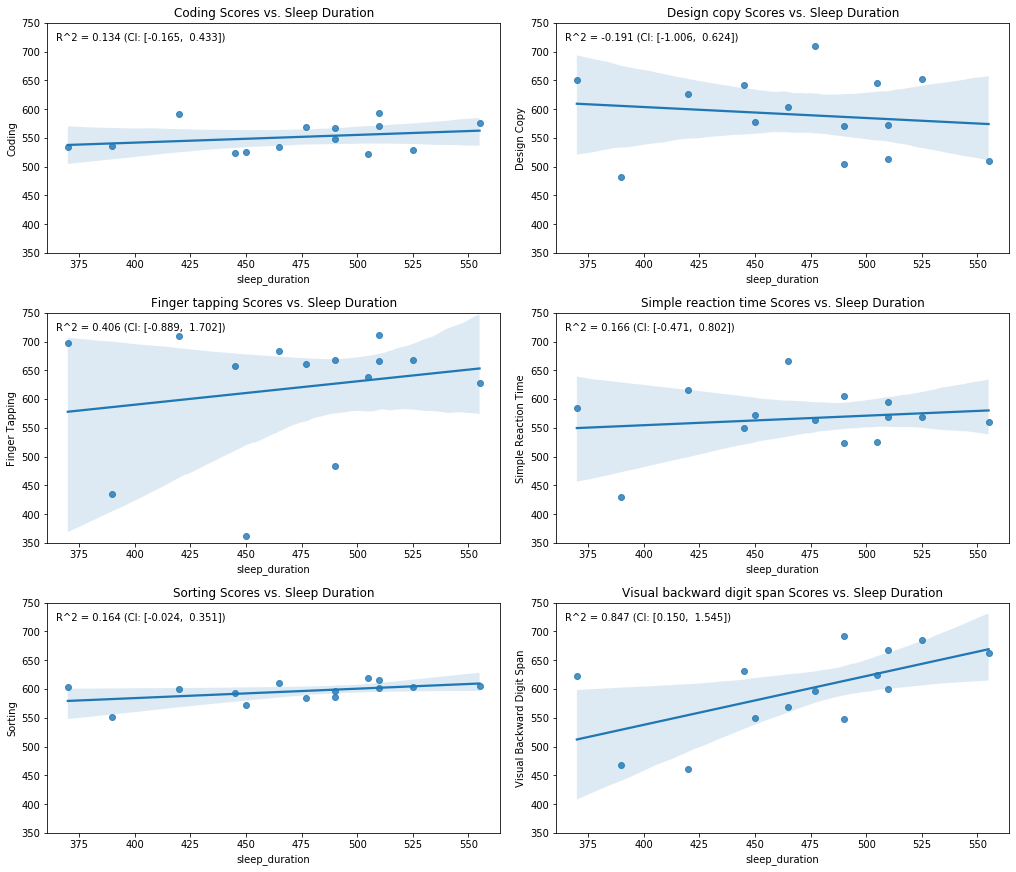

In [82]:
fig, axs = plt.subplots(nrows=len(test_result_cols) // 2, ncols=2, figsize=(14, 12), constrained_layout=True)
for i, col in enumerate(test_result_cols):
    ax = axs[i // 2, i % 2]
    ax.set_ylim((350, 750))
    res = sns.regplot(x='sleep_duration', y=col, ax=ax, data=labeled_sleep_qm_df)
    ax.set_title(f"{col.capitalize()} Scores vs. Sleep Duration")
    X = labeled_sleep_qm_df['sleep_duration'].values
    X = sm.add_constant(X)
    results = sm.OLS(labeled_sleep_qm_df[col].values, X).fit()
    ci = results.conf_int(alpha=0.05, cols=None)
    intercept, slope = results.params
    anc = AnchoredText(
        f"R^2 = {slope:.3f} (CI: [{ci[1, 0]:.3f}, {ci[1, 1]: .3f}])", loc="upper left", frameon=False
    )
    ax.add_artist(anc)

In [157]:
for i, col in enumerate(test_result_cols):
    X = labeled_sleep_qm_df['sleep_duration'].values
    X = sm.add_constant(X)
    results = sm.OLS(labeled_sleep_qm_df[col].values, X).fit()
    print(f"{col.capitalize()} Results")
    print("*" * 100)
    print(results.summary())
    print()
    print()

Coding Results
****************************************************************************************************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.9558
Date:                Wed, 09 Sep 2020   Prob (F-statistic):              0.348
Time:                        12:26:30   Log-Likelihood:                -64.317
No. Observations:                  14   AIC:                             132.6
Df Residuals:                      12   BIC:                             133.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

/home/stephenmalina/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


### Summary
While this is a very simple analysis, I think it pretty much shows that the results of the effect of sleep on my scores are inconclusive from this experiment. All of the OLS regression slopes except for visual backward digit span have confidence intervals that include 0. If anything, were I to do a follow-up experiment, I'd focus on the effect of sleep on QM results during a much longer period.